# End-to-End Algo Trading Pipeline (Single Notebook)

This notebook runs the entire workflow **without executing any bash scripts**:
1. Load raw anonymized per-asset OHLCV CSVs (`Asset_000..Asset_100`)
2. Clean + build a tradeable universe
3. Feature engineering + targets
4. Strategy modeling (Logic Sieve + LightGBM meta-labeling) with walk-forward
5. Backtesting + metrics + plots
6. Statistical arbitrage overlay exploration

Expected input folder: `data/raw/anonymized_data/Asset_###.csv`

In [1]:
import numpy as np
import pandas as pd

pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 140)
np.random.seed(42)

In [2]:
import importlib
from at.utils.paths import get_paths
import at.data.cleaning as cleaning
importlib.reload(cleaning)
CleaningConfig = cleaning.CleaningConfig
clean_anonymized_assets_folder = cleaning.clean_anonymized_assets_folder

import at.backtest.simulator as simulator
importlib.reload(simulator)
backtest_equal_weight = simulator.backtest_equal_weight
BacktestConfig = simulator.BacktestConfig

from at.features.build import build_feature_frame

from at.backtest.metrics import annualized_sharpe, max_drawdown
from at.viz.plots import plot_equity_curve, plot_underwater, plot_monthly_heatmap

from at.statsarb.pairs import top_correlated_pairs, cointegration_scan

In [3]:
paths = get_paths()
asset_dir = paths.data_raw / 'anonymized_data'
asset_dir

PosixPath('/home/manan/codes/precog/algorithmic-trading/data/raw/anonymized_data')

## 1) Load + clean each asset individually

This applies your Phase I cleaning rules per-asset and then concatenates the universe.

In [4]:
import re

asset_files = sorted(asset_dir.glob('Asset_*.csv'))
asset_ids = []
for p in asset_files:
    m = re.match(r'^Asset_(\d+)\.csv$', p.name)
    if m:
        asset_ids.append(int(m.group(1)))
asset_ids = sorted(asset_ids)

print(f'Found {len(asset_ids)} asset CSVs in {asset_dir}')
if asset_ids:
    print('Asset id range:', min(asset_ids), '->', max(asset_ids))
    print('Example ids:', asset_ids[:5], '...', asset_ids[-5:])

MAX_ASSETS = None
if MAX_ASSETS is not None:
    asset_ids = asset_ids[:MAX_ASSETS]
    print('Capped to first MAX_ASSETS:', MAX_ASSETS)

clean_cfg = CleaningConfig(
    max_missing_frac_per_ticker=0.20,
    fat_finger_return_clip=0.50,
    fat_finger_rolling_mean_window=5,
    min_price=5.0,
    min_dollar_volume=500_000.0,
    hampel_drop_anomalies=True,
    hampel_window_size=20,
    hampel_n_sigmas=3.0,
    hampel_downward_only=True, # Remove only crash-like dips
 )

df_clean, schema = clean_anonymized_assets_folder(
    asset_dir=asset_dir,
    asset_ids=asset_ids,
    filename_template='Asset_{i:03d}.csv',
    cfg=clean_cfg,
 )

df_clean.shape, df_clean['ticker'].nunique()

Found 100 asset CSVs in /home/manan/codes/precog/algorithmic-trading/data/raw/anonymized_data
Asset id range: 1 -> 100
Example ids: [1, 2, 3, 4, 5] ... [96, 97, 98, 99, 100]


((247199, 10), 100)

In [5]:
import matplotlib.pyplot as plt

from at.data.ingest import load_anonymized_asset_csv

fig_dir = paths.figures
fig_dir.mkdir(parents=True, exist_ok=True)

hampel_window = getattr(clean_cfg, "hampel_window_size", 10)
hampel_n_sigmas = getattr(clean_cfg, "hampel_n_sigmas", 3.0)
hampel_min_sigma_frac = getattr(clean_cfg, "hampel_min_sigma_frac", 0.008)
hampel_downward_only = getattr(clean_cfg, "hampel_downward_only", True)

# Limit plots to save time
MAX_PLOTS = 5
print(f"Generating Hampel anomaly plots (limit={MAX_PLOTS})...")

saved = 0
skipped_missing = 0
for i in asset_ids:
    if saved >= MAX_PLOTS:
        print(f"Reached limit of {MAX_PLOTS} plots. Stopping.")
        break
    
    csv_path = asset_dir / f"Asset_{i:03d}.csv"
    if not csv_path.exists():
        skipped_missing += 1
        continue

    df_i, s_i = load_anonymized_asset_csv(csv_path, ticker=f"Asset_{i:03d}")

    # Use the same pre-cleaning steps as the pipeline (but don't drop Hampel anomalies here)
    df_i = cleaning.forward_fill_small_gaps(df_i, s_i, clean_cfg)
    df_i = cleaning.fat_finger_fix(df_i, s_i, clean_cfg)
    df_i = cleaning.apply_hampel_filter(
        df_i,
        s=s_i,
        column=s_i.close,
        window_size=hampel_window,
        n_sigmas=hampel_n_sigmas,
        min_sigma_frac=hampel_min_sigma_frac,
        downward_only=hampel_downward_only,
    )

    fig, ax = cleaning.plot_hampel_filter_result(
        df_i,
        column=s_i.close,
        date_col=s_i.date,
        title=f"Asset_{i:03d} — Hampel anomalies (W={hampel_window}, n_sigmas={hampel_n_sigmas}, DownOnly={hampel_downward_only})",
    )
    out_path = fig_dir / f"hampel_asset_{i:03d}.png"
    fig.savefig(out_path, dpi=150, bbox_inches="tight")
    plt.close(fig)
    saved += 1

    if saved % 10 == 0:
        print(f"Saved {saved} plots...")

print(f"Saved plots: {saved} -> {fig_dir}")
if skipped_missing:
    print(f"Skipped missing CSVs: {skipped_missing}")


Generating Hampel anomaly plots (limit=5)...
Reached limit of 5 plots. Stopping.
Saved plots: 5 -> /home/manan/codes/precog/algorithmic-trading/reports/figures


In [6]:
df_clean.head()

,date,open,high,low,close,volume,ticker,rolling_median,outlier_score,is_anomaly
0,2016-01-25,29.178415,29.181290,28.514486,28.580592,249449990,Asset_001,28.580592,0.000000,False
1,2016-01-26,28.721415,28.994458,28.186822,28.738659,361581962,Asset_001,28.659626,0.275765,False
2,2016-01-28,26.956690,27.166502,26.554308,27.042913,268157355,Asset_001,27.811753,1.223238,False
3,2016-01-29,27.244108,27.977016,27.117645,27.977016,310239413,Asset_001,27.977016,0.000000,False
4,2016-02-01,27.726962,27.795941,27.419428,27.715465,197189966,Asset_001,27.846241,0.469635,False


## 2) Feature engineering + targets

Outputs a feature frame with a forward-looking target `fwd_ret_1d` (no leakage).

In [7]:
features = build_feature_frame(df_clean, schema)
features.shape

(247199, 19)

## 3) Phase A: Signal Factory (Layer 1) - Directional Predictor

We replace the static logic sieve with a dynamic ML model using **Recursive Expanding Window**.

**Logical Requirements:**
1. **Strict Separation (No Look-Ahead)**: At Month T, train only on Start $\to$ T-1.
2. **Model Independence**: A new LightGBM instance is initialized and trained from scratch each month.
3. **Output**: `layer1_prob` (0..1) stored as Out-of-Sample (OOS) predictions.

This creates the **Base Signal** (Bullish/Bearish).


In [9]:
df = features.copy()
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values(["date", "ticker"]).reset_index(drop=True)

Calculating 'Donchian Trend' indicators...
Loaded raw data for Asset_036 (rows=2511)

--- "Donchian Trend" on Asset_036 ---
Total Trades: 131
Win Rate:     29.77%
Strategy Sharpe: 1.0405
Benchmark Sharpe: 1.0828 (Raw Data used)


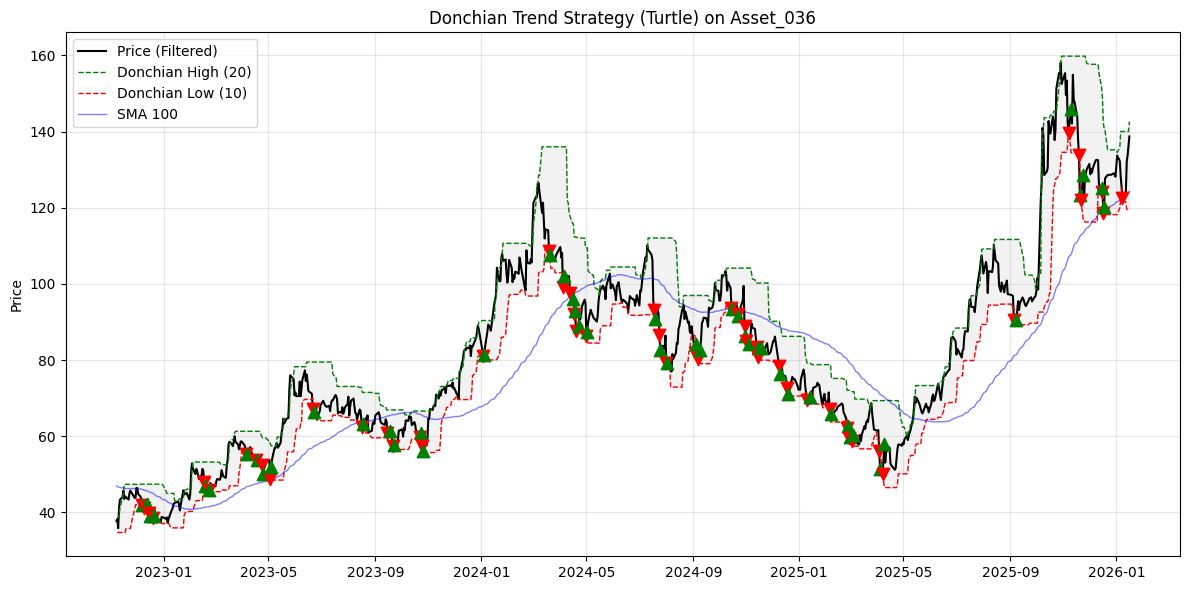

In [10]:
# "Donchian Trend" Strategy Implementation
# Replaces previous "Responsive Swing" logic

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from at.data.ingest import load_anonymized_asset_csv

def calc_rsi(series, period=9):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).ewm(alpha=1/period, adjust=False).mean()
    loss = (-delta.where(delta < 0, 0)).ewm(alpha=1/period, adjust=False).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

print("Calculating 'Donchian Trend' indicators...")

# Donchian Channels
# 20-day High (Entry basis) and 10-day Low (Exit basis)
# Transform ensures metrics are calculated per-ticker
df['don_high_20'] = df.groupby('ticker')['high'].transform(lambda x: x.rolling(20).max())
df['don_low_10']  = df.groupby('ticker')['low'].transform(lambda x: x.rolling(10).min())

# SMA 100 (Trend Filter)
df['sma_100'] = df.groupby('ticker')['close'].transform(lambda x: x.rolling(100).mean())

df['rsi_14'] = df.groupby('ticker')['close'].transform(lambda x: calc_rsi(x, 14))

# Create signal column: 1 = Entry, -1 = Exit
df['don_high_20_lag'] = df.groupby('ticker')['don_high_20'].shift(1)
df['don_low_10_lag']  = df.groupby('ticker')['don_low_10'].shift(1)

df['signal'] = 0

# Entry: Close > Yesterday's 20-Day High AND Close > SMA 100
entry_condition = (df['close'] > df['don_high_20_lag']) & (df['close'] > df['sma_100'])
df.loc[entry_condition, 'signal'] = 1

# Exit: Close < Yesterday's 10-Day Low
exit_condition = (df['close'] < df['don_low_10_lag'])
df.loc[exit_condition, 'signal'] = -1

df['signal_turtle_entry'] = (df['signal'] == 1).astype(int)
df['signal_a'] = df['signal_turtle_entry']

sample_ticker = df['ticker'].value_counts().idxmax() 
sdf = df[df['ticker'] == sample_ticker].copy().sort_values('date').reset_index(drop=True)

# --- LOAD RAW DATA FOR BENCHMARK ---
raw_path = asset_dir / f"{sample_ticker}.csv"
if raw_path.exists():
    raw_sdf, _ = load_anonymized_asset_csv(raw_path, ticker=sample_ticker)
    raw_sdf = raw_sdf.sort_values('date').reset_index(drop=True)
    print(f"Loaded raw data for {sample_ticker} (rows={len(raw_sdf)})")
else:
    print(f"Warning: Raw file not found for {sample_ticker}, using filtered data.")
    raw_sdf = sdf.copy()
# -----------------------------------

print(f"\n--- \"Donchian Trend\" on {sample_ticker} ---")

trades_log = []
pos_type = 0  # 0=Flat, 1=Long
entry_px = 0.0
entry_idx = 0

for i in range(21, len(sdf)): # Start after ramp-up
    curr_row = sdf.iloc[i]
    prev_row = sdf.iloc[i-1]
    
    # Pre-calc decision thresholds from Yesterday
    don_breakout_level = sdf.at[i-1, 'don_high_20']
    don_exit_level     = sdf.at[i-1, 'don_low_10']
    sma_filter         = curr_row['sma_100']

    # --- 1. HANDLE EXITS ---
    if pos_type == 1:
        # Exit Rule: Close < Donchian Low (10) of previous days
        if curr_row['close'] < don_exit_level:
            exit_px = curr_row['close']
            pnl = exit_px - entry_px
            hold_days = (curr_row['date'] - sdf.at[entry_idx, 'date']).days
            
            trades_log.append({
                'Entry Date': sdf.at[entry_idx, 'date'],
                'Type': 'Long',
                'Entry Price': entry_px,
                'Exit Date': curr_row['date'],
                'Exit Price': exit_px,
                'Reason': 'Donchian_Low_Break',
                'PnL': pnl,
                'HoldDays': hold_days
            })
            pos_type = 0
            continue

    # --- 2. HANDLE ENTRIES ---
    if pos_type == 0:
        # # Entry Rule: Close > Donchian High (20) AND Close > SMA 100
        # if (curr_row['close'] > don_breakout_level) and (curr_row['close'] > sma_filter):
        pos_type = 1
        entry_px = curr_row['close']
        entry_idx = i

# --- Reporting ---
trades_df = pd.DataFrame(trades_log)

# Calculate Benchmark Stats (Buy & Hold) for THIS ticker
if not trades_df.empty:
    start_date = trades_df['Entry Date'].min()
    end_date = sdf['date'].max()
    
    # --- BENCHMARK ON RAW DATA ---
    mask_bh = (raw_sdf['date'] >= start_date) & (raw_sdf['date'] <= end_date)
    bh_df = raw_sdf.loc[mask_bh].copy()
    
    # Benchmark PnL (Absolute price diff)
    if not bh_df.empty:
        bench_ret_abs = bh_df.iloc[-1]['close'] - bh_df.iloc[0]['close']
        
        # Benchmark Sharpe
        bh_df['daily_ret'] = bh_df['close'].pct_change()
        bench_sharpe = (bh_df['daily_ret'].mean() / bh_df['daily_ret'].std()) * np.sqrt(252)
    else:
        bench_ret_abs = 0.0
        bench_sharpe = 0.0
    # -----------------------------
   
    # Strategy Sharpe 
    sdf['daily_ret'] = sdf['close'].pct_change()
    sdf['strat_ret'] = 0.0
    
    # Mark Long Days
    long_mask = pd.Series(0, index=sdf.index)
    for idx, row in trades_df.iterrows():
        # Find start and end indices in sdf
        e_date = row['Entry Date']
        x_date = row['Exit Date']
        mask = (sdf['date'] > e_date) & (sdf['date'] <= x_date)
        sdf.loc[mask, 'strat_ret'] = sdf.loc[mask, 'daily_ret']
        
    strat_sharpe = (sdf['strat_ret'].mean() / sdf['strat_ret'].std()) * np.sqrt(252)
    
    total_trades = len(trades_df)
    win_rate = (trades_df['PnL'] > 0).sum() / total_trades
    print(f"Total Trades: {total_trades}")
    print(f"Win Rate:     {win_rate:.2%}")
    print(f"Strategy Sharpe: {strat_sharpe:.4f}")
    print(f"Benchmark Sharpe: {bench_sharpe:.4f} (Raw Data used)")
    
else:
    print("No trades generated.")


# --- Plotting ---
plot_days = 800
p_df = sdf.iloc[-plot_days:].copy()

fig, axes = plt.subplots(1, 1, figsize=(12, 6))
ax = axes

# Price
ax.plot(p_df['date'], p_df['close'], color='black', linewidth=1.5, label='Price (Filtered)')

# Donchian Channels
# Shift by 1 because the breakout level for Today is determined by Yesterday's window
ax.plot(p_df['date'], p_df['don_high_20'].shift(1), color='green', linewidth=1, linestyle='--', label='Donchian High (20)')
ax.plot(p_df['date'], p_df['don_low_10'].shift(1), color='red', linewidth=1, linestyle='--', label='Donchian Low (10)')
ax.fill_between(p_df['date'], p_df['don_high_20'].shift(1), p_df['don_low_10'].shift(1), color='gray', alpha=0.1)

# SMA 100
ax.plot(p_df['date'], p_df['sma_100'], color='blue', linewidth=1, alpha=0.5, label='SMA 100')

# Trades
for t in trades_log:
    if t['Entry Date'] >= p_df['date'].min():
        ax.scatter(t['Entry Date'], t['Entry Price'], color='green', marker='^', s=80, zorder=5)
    if t['Exit Date'] >= p_df['date'].min():
        ax.scatter(t['Exit Date'], t['Exit Price'], color='red', marker='v', s=80, zorder=5)

ax.set_title(f"Donchian Trend Strategy (Turtle) on {sample_ticker}")
ax.set_ylabel("Price")
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4) Phase B: Meta-Labeling (LightGBM)

We train a **meta-labeler** that learns which Model A signals are likely to win.

Key constraints:
- **Time-ordered splits only** (no shuffle)
- **Purged / embargo gap** between train and test to reduce leakage

In [11]:
# Step 1: Candidate set + meta-features (robust, stationary; no raw prices as features)
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller

df = df.copy()
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values(["date", "ticker"]).reset_index(drop=True)

# If needed, compute a forward return target for meta-labeling (1d)
if "fwd_ret_1d" not in df.columns:
    df["fwd_ret_1d"] = df.groupby("ticker")["close"].pct_change(1).shift(-1)

# --- FracDiff Helper Functions ---

def get_weights_fixed(d, size):
    """Generate weights for fixed-width fractional differentiation."""
    w = [1.0]
    for k in range(1, size):
        w_k = -w[-1] / k * (d - k + 1)
        w.append(w_k)
    return np.array(w[::-1])


def get_weights_ffd(d: float, thresh: float = 1e-5) -> np.ndarray:
    """Fixed-Width Fractional Differentiation weights (Lopez de Prado style).

    We expand weights until the next weight magnitude drops below `thresh`.
    """
    w = [1.0]
    k = 1
    while True:
        w_k = -w[-1] / k * (d - k + 1)
        if abs(w_k) < thresh:
            break
        w.append(w_k)
        k += 1
        if k > 10_000:
            break
    return np.array(w[::-1], dtype=float)


def frac_diff_ffd(series: pd.Series, d: float, *, thresh: float = 1e-5) -> pd.Series:
    """Apply fixed-width fractional differentiation to a 1D series."""
    s = pd.to_numeric(series, errors="coerce").astype(float)
    w = get_weights_ffd(float(d), float(thresh))
    width = int(len(w))
    if width <= 0:
        return pd.Series(np.nan, index=s.index)
    return s.rolling(window=width, min_periods=width).apply(lambda x: float(np.dot(w, x)), raw=True)


def plot_min_ffd(
    series: pd.Series,
    *,
    ds: np.ndarray | None = None,
    thresh: float = 1e-5,
    adf_alpha: float = 0.05,
    maxlag: int = 1,
    regression: str = "c",
    autolag=None,
    show_plot: bool = True,
) -> pd.DataFrame:
    """Find the minimum fractional differencing d that passes ADF @ 95% confidence.

    Returns a DataFrame with columns: d, pval, corr.
    - pval: ADF p-value on frac-diffed series
    - corr: correlation between original and frac-diffed series (memory proxy)

    Notes:
    - For speed/stability, this should generally be run on a recent tail slice.
    - `show_plot` is useful for single-asset inspection; keep False in batch runs.
    """

    import matplotlib.pyplot as plt

    s = pd.to_numeric(series, errors="coerce").dropna().astype(float)
    if ds is None:
        ds = np.round(np.arange(0.0, 1.01, 0.02), 2)

    rows = []
    for d in ds:
        try:
            diffed = frac_diff_ffd(s, float(d), thresh=thresh).dropna()
            if len(diffed) < 50:
                continue

            aligned = s.loc[diffed.index]
            if len(aligned) != len(diffed):
                continue

            res = adfuller(diffed.values, maxlag=maxlag, regression=regression, autolag=autolag)
            pval = float(res[1])

            corr = float(np.corrcoef(aligned.values, diffed.values)[0, 1])
            if not np.isfinite(corr):
                corr = np.nan

            rows.append({"d": float(d), "pval": pval, "corr": corr})
        except Exception:
            continue

    out = pd.DataFrame(rows).sort_values("d").reset_index(drop=True)

    if show_plot and not out.empty:
        fig, ax1 = plt.subplots(figsize=(8, 4))
        ax1.plot(out["d"], out["pval"], marker="o", color="purple", label="ADF p-value")
        ax1.axhline(adf_alpha, color="gray", linestyle="--", linewidth=1.0, label=f"p={adf_alpha:.2f}")
        ax1.set_xlabel("d")
        ax1.set_ylabel("ADF p-value")
        ax1.set_ylim(0, 1)
        ax1.grid(True, alpha=0.25)

        ax2 = ax1.twinx()
        ax2.plot(out["d"], out["corr"], marker=".", color="teal", alpha=0.8, label="Corr (memory)")
        ax2.set_ylabel("Correlation(original, frac-diff)")

        passing = out[out["pval"] < adf_alpha]
        if not passing.empty:
            d_star = float(passing["d"].min())
            c_star = float(out.loc[out["d"] == d_star, "corr"].iloc[0])
            plt.title(f"Minimum d passing ADF: {d_star:.2f} (corr={c_star:.2f})")
        else:
            plt.title("No d passed ADF in grid")

        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc="best")
        plt.tight_layout()
        plt.show()

    return out


def get_frac_diff_features(
    df,
    close_col: str = "close",
    group_col: str = "ticker",
    d_default: float | None = None,
    window: int = 100,
    optimize_d: bool = True,
    *,
    d_grid: np.ndarray | None = None,
    adf_alpha: float = 0.05,
    thresh: float = 1e-5,
    max_obs_for_adf: int = 2000,
    fallback_d: float = 1.0,
    verbose: bool = False,
    plot_first_n: int = 0,
):
    """Applies Fixed-Width Fractional Differentiation (FFD) to close price.

    Leakage note:
    - If `optimize_d=True`, this estimates d per asset by running ADF on a tail slice of the
      *full* series passed in. That is not causal for earlier timestamps.
    - For a causal pipeline, pass `optimize_d=False` and set a fixed `d_default`, or re-fit d
      inside each walk-forward training window.

    Stores results in:
    - frac_diff_close
    - ffd_d_close (selected d per row)
    """

    out = df.copy()

    if d_grid is None:
        d_grid = np.round(np.arange(0.0, 1.01, 0.02), 2)

    out["frac_diff_close"] = np.nan
    out["ffd_d_close"] = np.nan

    groups = out.groupby(group_col, sort=False)
    if optimize_d:
        print(f"Calculating FracDiff (FFD) per-asset min d via ADF@{int((1-adf_alpha)*100)}%...")
    else:
        d_msg = "fallback" if d_default is None else f"d_default={float(d_default):.2f}"
        print(f"Calculating FracDiff (FFD) with fixed d ({d_msg})...")

    plotted = 0
    chosen_ds = {}

    for gname, idx in groups.groups.items():
        x_full = pd.to_numeric(out.loc[idx, close_col], errors="coerce").astype(float)

        x_tail = x_full.dropna()
        if max_obs_for_adf is not None and max_obs_for_adf > 0:
            x_tail = x_tail.iloc[-int(max_obs_for_adf):]

        if optimize_d and len(x_tail) >= 200:
            show_plot = plotted < int(plot_first_n)
            res_df = plot_min_ffd(
                x_tail,
                ds=d_grid,
                thresh=thresh,
                adf_alpha=adf_alpha,
                maxlag=1,
                regression="c",
                autolag=None,
                show_plot=show_plot,
            )
            if show_plot:
                plotted += 1

            passing = res_df[res_df["pval"] < adf_alpha] if not res_df.empty else pd.DataFrame()
            if not passing.empty:
                d_sel = float(passing["d"].min())
            else:
                d_sel = float(fallback_d)
        else:
            if d_default is None:
                d_sel = float(fallback_d)
            else:
                d_sel = float(d_default)

        chosen_ds[gname] = d_sel

        out.loc[idx, "frac_diff_close"] = frac_diff_ffd(x_full, d_sel, thresh=thresh).values
        out.loc[idx, "ffd_d_close"] = d_sel

        if verbose:
            print(f"{gname}: d={d_sel:.2f} (n={int(x_full.notna().sum())})")

    if len(chosen_ds) > 0:
        d_vals = pd.Series(chosen_ds).astype(float)
        print("Selected d stats:")
        # display(d_vals.describe())

    return out



def add_stationary_features(
    d: pd.DataFrame,
    *,
    close_col: str = "close",
    high_col: str = "high",
    low_col: str = "low",
    open_col: str = "open",
    volume_col: str = "volume",
    group_col: str = "ticker",
    rsi_col: str = "rsi_14",
    bb_window: int = 20,
    sma_fast: int = 50,
    sma_slow: int = 200,
    vol_short: int = 20,
    vol_long: int = 100,
) -> tuple[pd.DataFrame, list[str]]:
    """Add a robust, stationary feature set (no raw prices as features)."""
    out = d.copy()

    # 0) Apply Fractional Differentiation (Stationarity Preserving)
    # NOTE: We disable optimize_d to avoid non-causal tail-optimization leakage.
    FRACDIFF_D = 0.50
    out = get_frac_diff_features(
        out,
        close_col=close_col,
        group_col=group_col,
        optimize_d=False,
        d_default=FRACDIFF_D,
        adf_alpha=0.05,
        thresh=1e-5,
        max_obs_for_adf=2000,
        fallback_d=1.0,
        verbose=False,
        plot_first_n=0,
    )

    g = out.groupby(group_col, sort=False)

    if rsi_col not in out.columns:
        raise KeyError(f"Missing {rsi_col}. Re-run feature engineering so RSI is present.")

    # 1) Log returns (momentum)
    for n in (1, 5, 10, 21):
        out[f"log_ret_{n}d"] = g[close_col].transform(
            lambda x: np.log(x.astype(float).replace(0, np.nan) / x.astype(float).replace(0, np.nan).shift(n))
        )

    # -----------------------------------------------------------------------------
    # Regime Context Features (what regime are we in?)
    # These aim to help the meta-model identify when the primary signal fails.
    # We avoid hard dependencies; GARCH-style clustering is approximated via EWMA vols.
    # -----------------------------------------------------------------------------

    # Volatility clustering / GARCH-like metrics (RiskMetrics EWMA is a constrained GARCH)
    out["ewm_vol_20"] = g["log_ret_1d"].transform(lambda x: x.ewm(span=20, adjust=False).std(bias=False))
    out["_ewm_vol_100"] = g["log_ret_1d"].transform(lambda x: x.ewm(span=100, adjust=False).std(bias=False))
    out["vol_cluster_ratio"] = out["ewm_vol_20"] / out["_ewm_vol_100"].replace(0, np.nan)

    # Vol-of-vol: volatility of recent vol estimate (captures clustering intensity)
    out["vol_of_vol_20"] = g["ewm_vol_20"].transform(lambda x: x.rolling(20, min_periods=20).std(ddof=0))

    # Return serial correlation (already used, but keep as regime context too)
    out["serial_corr_20"] = g["log_ret_1d"].transform(
        lambda x: x.rolling(20).apply(lambda y: y.autocorr(lag=1), raw=False),
    )

    # Optional: order book imbalance / RQP (only if order-book columns exist)
    # If not available, use a simple OHLCV proxy: volume-weighted bar pressure.
    if {"bid_size", "ask_size"}.issubset(set(out.columns)):
        denom = (out["bid_size"].astype(float) + out["ask_size"].astype(float)).replace(0, np.nan)
        out["order_imbalance"] = (out["bid_size"].astype(float) - out["ask_size"].astype(float)) / denom
    else:
        # Proxy for aggressive buying/selling within the bar
        if {open_col, high_col, low_col}.issubset(set(out.columns)):
            rng = (out[high_col].astype(float) - out[low_col].astype(float)).replace(0, np.nan)
            bar_pressure = (out[close_col].astype(float) - out[open_col].astype(float)) / rng
            bar_pressure = bar_pressure.clip(-1.0, 1.0).fillna(0.0)
            # Liquidity-normalized volume pressure
            vol_sma20 = g[volume_col].transform(lambda x: x.rolling(20, min_periods=20).mean())
            out["order_imbalance"] = bar_pressure * (out[volume_col].astype(float) / vol_sma20.replace(0, np.nan))
        else:
            out["order_imbalance"] = np.nan

    # 2) Volatility regimes (existing)
    out["roll_vol_20d"] = g["log_ret_1d"].transform(lambda x: x.rolling(vol_short, min_periods=vol_short).std(ddof=0))
    out["_roll_vol_100d"] = g["log_ret_1d"].transform(lambda x: x.rolling(vol_long, min_periods=vol_long).std(ddof=0))
    out["vol_ratio"] = out["roll_vol_20d"] / out["_roll_vol_100d"]

    out["vol_regime_ratio"] = g["log_ret_1d"].transform(
        lambda x: x.rolling(21).std(ddof=0) / x.rolling(63).std(ddof=0).replace(0, np.nan),
    )

    # Bollinger Band width (normalized)
    out["_bb_mid"] = g[close_col].transform(lambda x: x.rolling(bb_window, min_periods=bb_window).mean())
    out["_bb_std"] = g[close_col].transform(lambda x: x.rolling(bb_window, min_periods=bb_window).std(ddof=0))
    out["bb_width"] = (4.0 * out["_bb_std"]) / out["_bb_mid"]

    # 3) Relative strength / extension
    out["_sma_50"] = g[close_col].transform(lambda x: x.rolling(sma_fast, min_periods=sma_fast).mean())
    out["_sma_200"] = g[close_col].transform(lambda x: x.rolling(sma_slow, min_periods=sma_slow).mean())
    out["dist_sma50"] = (out[close_col] / out["_sma_50"]) - 1.0
    out["dist_sma200"] = (out[close_col] / out["_sma_200"]) - 1.0

    # NEW: Market Breadth (% of constituents > SMA200)
    out["is_above_sma200"] = (out[close_col] > out["_sma_200"]).astype(float)
    daily_breadth = out.groupby("date")["is_above_sma200"].transform("mean")
    out["market_breadth"] = daily_breadth

    # 4) Volume dynamics / liquidity regime
    out["vol_change"] = g[volume_col].transform(
        lambda x: np.log(x.astype(float).replace(0, np.nan) / x.astype(float).replace(0, np.nan).shift(1)),
    )
    out["rel_vol"] = out[volume_col] / g[volume_col].transform(lambda x: x.rolling(20, min_periods=20).mean())

    vol_ma_5 = g[volume_col].transform(lambda x: x.rolling(5).mean())
    vol_ma_20 = g[volume_col].transform(lambda x: x.rolling(20).mean())
    out["volume_oscillator"] = (vol_ma_5 - vol_ma_20) / vol_ma_20.replace(0, np.nan)

    # 5) Time Attributes
    out["day_of_week"] = out["date"].dt.dayofweek  # 0=Mon, 4=Fri
    out["is_friday"] = (out["day_of_week"] == 4).astype(float)

    # 6) Volatility / ATR (Normalized)
    out["_tr1"] = (out[high_col] - out[low_col]).abs()
    out["_tr2"] = (out[high_col] - out[close_col].shift(1)).abs()
    out["_tr3"] = (out[low_col] - out[close_col].shift(1)).abs()
    out["_tr"] = out[["_tr1", "_tr2", "_tr3"]].max(axis=1)
    out["_atr"] = g["_tr"].transform(lambda x: x.rolling(14).mean())
    out["atr_ratio"] = out["_atr"] / out[close_col]

    if "bid" in out.columns and "ask" in out.columns:
        out["bid_ask_spread"] = (out["ask"] - out["bid"]) / out["ask"]

    out["high_low_range"] = (out[high_col] - out[low_col]) / out[close_col]
    denom = (out[high_col] - out[low_col]).astype(float)
    out["close_loc"] = (out[close_col] - out[low_col]) / denom.replace(0, np.nan)

    out = out.replace([np.inf, -np.inf], np.nan)

    feature_cols = [
        "frac_diff_close",
        "vol_regime_ratio",
        "vol_cluster_ratio",
        "vol_of_vol_20",
        "order_imbalance",
        "market_breadth",
        "volume_oscillator",
        rsi_col,
        "log_ret_1d",
        "log_ret_5d",
        "log_ret_10d",
        "log_ret_21d",
        "bb_width",
        "dist_sma50",
        "dist_sma200",
        "high_low_range",
        "close_loc",
        "serial_corr_20",
        "day_of_week",
        "atr_ratio",
        "rel_vol",
    ]
    if "bid_ask_spread" in out.columns:
        feature_cols.append("bid_ask_spread")

    feature_cols = [c for c in feature_cols if c in out.columns]
    return out, feature_cols

In [12]:
# Step 2: LightGBM meta-label model with strict walk-forward (purged) CV
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, average_precision_score, log_loss
import matplotlib.pyplot as plt
import lightgbm as lgb


def calculate_daily_volatility(df, span=100):
    df["volatility"] = df.groupby("ticker")["close"].transform(
        lambda x: x.pct_change().ewm(span=span).std()
    )
    return df



def _get_continuous_position(entry: np.ndarray, exit: np.ndarray) -> np.ndarray:
    out = np.zeros(len(entry), dtype=int)
    current_pos = 0
    for i in range(len(entry)):
        if current_pos == 1:
            if bool(exit[i]):
                current_pos = 0
        else:
            if bool(entry[i]):
                current_pos = 1
        out[i] = current_pos
    return out


def build_primary_trade_events(
    df: pd.DataFrame,
    min_trade_ret: float = 0.0,
) -> pd.DataFrame:
    """
    - entry: close > shift(1).rolling(20).max(high) AND close > sma100
    - exit:  close < shift(1).rolling(10).min(low)
    """

    out = df.copy()
    out["date"] = pd.to_datetime(out["date"])
    out = out.sort_values(["date", "ticker"]).reset_index(drop=True)

    out["_don_high_20"] = out.groupby("ticker")["high"].transform(
        lambda x: x.shift(1).rolling(20).max()
    )
    out["_don_low_10"] = out.groupby("ticker")["low"].transform(
        lambda x: x.shift(1).rolling(10).min()
    )
    out["_sma_100"] = out.groupby("ticker")["close"].transform(
        lambda x: x.rolling(100).mean()
    )

    entry_cond = (out["close"] > out["_don_high_20"]) & (out["close"] > out["_sma_100"])
    exit_cond = out["close"] < out["_don_low_10"]

    tmp = out[["date", "ticker"]].copy()
    tmp["entry"] = entry_cond.fillna(False)
    tmp["exit"] = exit_cond.fillna(False)

    tmp["pos_primary"] = tmp.groupby("ticker", group_keys=False).apply(
        lambda g: pd.Series(
            _get_continuous_position(g["entry"].to_numpy(), g["exit"].to_numpy()), index=g.index
        )
    )

    out["pos_primary"] = tmp["pos_primary"].astype(int)

    prev_pos = out.groupby("ticker")["pos_primary"].shift(1).fillna(0).astype(int)
    out["primary_entry"] = (out["pos_primary"] == 1) & (prev_pos == 0)

    out["primary_trade_id"] = out.groupby("ticker")["primary_entry"].cumsum().astype(int)

    out["_daily_ret"] = out.groupby("ticker")["close"].pct_change().astype(float)

    held = out.loc[
        out["pos_primary"] == 1, ["date", "ticker", "primary_trade_id", "_daily_ret"]
    ].copy()
    held["_daily_ret"] = held["_daily_ret"].fillna(0.0)

    trade_ret = held.groupby(["ticker", "primary_trade_id"])["_daily_ret"].apply(
        lambda x: float((1.0 + x).prod() - 1.0)
    )
    exit_date = held.groupby(["ticker", "primary_trade_id"])["date"].max()

    trades = (
        pd.DataFrame({"trade_ret": trade_ret, "t1": exit_date})
        .reset_index()
        .sort_values(["ticker", "primary_trade_id"])
    )

    entries = out.loc[out["primary_entry"], ["date", "ticker", "primary_trade_id"]].copy()
    entries = entries.merge(trades, on=["ticker", "primary_trade_id"], how="left")

    entries["meta_y"] = (entries["trade_ret"] >= float(min_trade_ret)).astype(int)

    entries["primary_entry"] = True

    return entries


# --- Feature engineering ---
df, feature_cols_local = add_stationary_features(df)
df = calculate_daily_volatility(df, span=100)
print("Features & Volatility computed.")

MIN_TRADE_RET = 0.0
cand_events = build_primary_trade_events(df, min_trade_ret=MIN_TRADE_RET)

cand = df.merge(
    cand_events,
    on=["date", "ticker"],
    how="left",
    validate="many_to_one",
)

cand = cand.loc[cand["primary_entry"].fillna(False)].copy()

cand = cand.replace([np.inf, -np.inf], np.nan)
cand = cand.dropna(subset=["meta_y", "date", "t1", "trade_ret"] + feature_cols_local).copy()

X = cand[feature_cols_local]
y = cand["meta_y"].astype(int).to_numpy()
dates = pd.to_datetime(cand["date"]).to_numpy()
t1 = pd.to_datetime(cand["t1"]).to_numpy()


class WalkForwardPurgedKFold:
    """Strict walk-forward splitter: train strictly on the past, test on the next block.

    Purging rule:
    - For a test block that starts at time T, drop any training sample whose eval_time (t1)
      is >= T (overlaps into the test window).

    This avoids the non-causal CPCV pattern where the model can train on samples that occur
    after the test fold in calendar time.
    """

    def __init__(self, n_splits: int = 6):
        if n_splits < 2:
            raise ValueError("n_splits must be >= 2")
        self.n_splits = int(n_splits)

    def split(self, X, y=None, pred_times=None, eval_times=None):
        if pred_times is None or eval_times is None:
            raise ValueError("pred_times and eval_times are required")

        n_samples = len(X)
        indices = np.arange(n_samples)

        pred_times = pd.to_datetime(pred_times).to_numpy()
        eval_times = pd.to_datetime(eval_times).to_numpy()

        # Split on unique prediction times so we don't break same-day events across folds
        uniq_times = np.sort(np.unique(pred_times))
        time_folds = np.array_split(uniq_times, self.n_splits)

        for fold_idx, test_times in enumerate(time_folds, start=1):
            if len(test_times) == 0:
                continue

            test_start = test_times.min()

            test_mask = np.isin(pred_times, test_times)
            test_indices = indices[test_mask]

            train_mask = pred_times < test_start
            train_indices = indices[train_mask]

            # Purge overlaps into test window
            if len(train_indices) > 0:
                keep = eval_times[train_indices] < test_start
                train_indices = train_indices[keep]

            if len(train_indices) == 0 or len(test_indices) == 0:
                continue

            yield train_indices, test_indices


pos = int(y.sum())
neg = int((y == 0).sum())

ratio = neg / pos if pos > 0 else 1.0
if 0.66 < ratio < 1.5:
    print(f"Classes are roughly balanced (Neg/Pos={ratio:.2f}). Disabling scale_pos_weight.")
    scale_pos_weight = 1.0
else:
    print(f"Classes are unbalanced (Neg/Pos={ratio:.2f}). Using scale_pos_weight={ratio:.2f}.")
    scale_pos_weight = ratio

cv = WalkForwardPurgedKFold(n_splits=6)

params = dict(
    objective="binary",
    metric="binary_logloss",
    num_leaves=30,
    feature_fraction=0.7,
    min_child_samples=501,
    learning_rate=0.05,
    n_estimators=2000,
    subsample=0.9,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight,
    verbose=-1,
)

oof = np.full(len(cand), np.nan, dtype=float)
fold_scores = []
models = []

print(f"Starting Walk-Forward Purged CV Training... (Splits={cv.n_splits})")

for fold, (tr, te) in enumerate(cv.split(X, y, pred_times=dates, eval_times=t1), start=1):
    X_tr, y_tr = X.iloc[tr], y[tr]
    X_te, y_te = X.iloc[te], y[te]

    if len(X_tr) < 100 or len(X_te) == 0:
        continue

    clf = lgb.LGBMClassifier(**params)

    clf.fit(
        X_tr,
        y_tr,
        eval_set=[(X_te, y_te)],
        eval_metric="binary_logloss",
        callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)],
    )

    prob = clf.predict_proba(X_te)[:, 1]
    oof[te] = prob

    models.append(clf)

    auc = roc_auc_score(y_te, prob) if len(np.unique(y_te)) > 1 else np.nan
    ll = log_loss(y_te, prob) if len(np.unique(y_te)) > 1 else np.nan

    fold_scores.append(
        {
            "fold": fold,
            "auc": float(auc),
            "log_loss": float(ll),
            "n_train": len(X_tr),
            "n_test": len(X_te),
        }
    )
    print(f"Fold {fold}: LogLoss={ll:.4f} AUC={auc:.4f} Tr={len(X_tr)} Te={len(X_te)}")

scores_df = pd.DataFrame(fold_scores)
print("\nWalk-forward CV Summary:")
display(scores_df.describe())

cand["meta_prob"] = oof

merge_cols = ["date", "ticker", "meta_prob", "meta_y", "trade_ret", "t1"]
if "meta_prob" in df.columns:
    df = df.drop(columns=["meta_prob"])

df = df.merge(cand[merge_cols], on=["date", "ticker"], how="left")
print("Done. Predictions merged.")

Calculating FracDiff (FFD) with fixed d (d_default=0.50)...
Selected d stats:
Features & Volatility computed.
Classes are unbalanced (Neg/Pos=0.27). Using scale_pos_weight=0.27.
Starting Walk-Forward Purged CV Training... (Splits=6)
Fold 1: LogLoss=0.5177 AUC=0.5000 Tr=388 Te=404
Fold 2: LogLoss=0.6100 AUC=0.5000 Tr=832 Te=442
Fold 3: LogLoss=0.4783 AUC=0.6026 Tr=1248 Te=389
Fold 4: LogLoss=0.5060 AUC=0.5886 Tr=1623 Te=365
Fold 5: LogLoss=0.5202 AUC=0.6439 Tr=2001 Te=345

Walk-forward CV Summary:


,fold,auc,log_loss,n_train,n_test
count,5.000000,5.000000,5.000000,5.000000,5.000000
mean,3.000000,0.567026,0.526430,1218.400000,389.000000
std,1.581139,0.064476,0.049563,635.592086,37.235736
min,1.000000,0.500000,0.478286,388.000000,345.000000
25%,2.000000,0.500000,0.506014,832.000000,365.000000
50%,3.000000,0.588581,0.517743,1248.000000,389.000000
75%,4.000000,0.602649,0.520151,1623.000000,404.000000
max,5.000000,0.643901,0.609956,2001.000000,442.000000


Done. Predictions merged.


In [13]:
if "meta_prob" not in df.columns:
    raise KeyError("meta_prob not found. Run the LightGBM meta-labeling cell first.")

print("meta_prob coverage (non-null):", int(df["meta_prob"].notna().sum()))
df[["meta_prob"]].describe()
print()
# lgb.plot_importance(models[0], importance_type="gain", max_num_features=10)

meta_prob coverage (non-null): 1945



## 5) Backtesting

We compare:
- **Logic only** (Model A)
- **Logic + meta filter** (Model A gated by meta probability threshold)

Costs:
- Commission: 10 bps
- Slippage: square-root impact toy model

In [ ]:
import importlib
import at.backtest.simulator
importlib.reload(at.backtest.simulator)
from at.backtest.simulator import backtest_equal_weight, BacktestConfig

from at.backtest.metrics import annualized_sharpe, max_drawdown

bt_cfg = BacktestConfig(
    initial_capital=1_000_000.0,
    commission_bps=10.0,
    impact_k=0.10,
    max_gross_leverage=1.0,
 )

df = df.drop_duplicates(subset=["date", "ticker"], keep="last").copy()
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values(["date", "ticker"]).reset_index(drop=True)


print("Re-calculating Donchian Strategy State (Entry to Exit)...")

# Indicators
df['_don_high_20'] = df.groupby('ticker')['high'].transform(lambda x: x.shift(1).rolling(20).max())
df['_don_low_10']  = df.groupby('ticker')['low'].transform(lambda x: x.shift(1).rolling(10).min())
df['_sma_100'] = df.groupby('ticker')['close'].transform(lambda x: x.rolling(100).mean())

entry_cond = (df['close'] > df['_don_high_20']) & (df['close'] > df['_sma_100'])
exit_cond = (df['close'] < df['_don_low_10'])

def get_continuous_position(group):
    entries = group['entry'].values
    exits = group['exit'].values
    out = np.zeros(len(entries), dtype=int)

    current_pos = 0
    for i in range(len(entries)):

        if current_pos == 1:
            if exits[i]:
                current_pos = 0
        else: # current_pos == 0
            if entries[i]:
                current_pos = 1

        out[i] = current_pos

    return out

temp = df[['date', 'ticker']].copy()
temp['entry'] = entry_cond.fillna(False)
temp['exit'] = exit_cond.fillna(False)

temp['pos_primary'] = temp.groupby('ticker', group_keys=False).apply(
    lambda x: pd.Series(get_continuous_position(x), index=x.index)
)

if "meta_prob" not in df.columns:
    print("WARNING: meta_prob missing. Defaulting to all zeros.")
    df["meta_prob"] = 0.0

global_thr = float(globals().get("META_THR", 0.60))
global_thr = float(np.clip(global_thr, 0.0, 1.0))
print(f"Computing Meta-Strategy Paths (Threshold: {global_thr:.4f})...")

# Check distribution of meta_prob on Entries
candidates = df.loc[entry_cond, "meta_prob"].dropna()
if len(candidates) > 0:
    print("Meta-prob stats on valid signals:\n", candidates.describe())
    prob_p90 = candidates.quantile(0.90)

    max_prob = candidates.max()
    if global_thr > max_prob:
        print(
            f"Warning: Threshold ({global_thr:.4f}) > Max Prob ({max_prob:.4f}). Meta strategy will have 0 trades."
        )
    elif global_thr > prob_p90:
        print(f"Warning: Threshold ({global_thr:.4f}) is very high (> P90).")

META_THR = global_thr

# Filter Entry Condition
meta_entry_cond = entry_cond & (df["meta_prob"].fillna(0) >= global_thr)

print(f"Total Base Entries: {int(entry_cond.sum())}")
print(f"Meta-Filtered Entries: {int(meta_entry_cond.sum())}")

if int(meta_entry_cond.sum()) == 0:
    print("WARNING: Meta strategy has 0 trades at this threshold.")

# Re-use temp structure for meta calculation
temp_meta = df[['date', 'ticker']].copy()
temp_meta['entry'] = meta_entry_cond.fillna(False)
temp_meta['exit'] = exit_cond.fillna(False) # Exits are same as original logic

temp['pos_meta'] = temp_meta.groupby('ticker', group_keys=False).apply(
    lambda x: pd.Series(get_continuous_position(x), index=x.index)
)

# Merge back to df
df['signal_benchmark'] = 1
df['signal_primary'] = temp['pos_primary']
df['signal_meta'] = temp['pos_meta']

# --- 3. Weighting & Backtest ---
if "roll_vol_20d" in df.columns:
    df["weight"] = 1.0 / (df["roll_vol_20d"].astype(float) + 1e-9)
elif "vol_20d" in df.columns:
    df["weight"] = 1.0 / (df["vol_20d"].astype(float) + 1e-9)
else:
    df["weight"] = 1.0

# Clip extreme weights
df["weight"] = df["weight"].clip(upper=2.0)

# Diagnostics
days = df['date'].nunique()
avg_hold_prim = df[df['signal_primary']==1].shape[0] / days
avg_hold_meta = df[df['signal_meta']==1].shape[0] / days
print(f"Avg Positions Held/Day | Primary: {avg_hold_prim:.1f} | Meta: {avg_hold_meta:.1f}")

print("\nRunning Backtests...")
res_bh = backtest_equal_weight(df, signal_col="signal_benchmark", weight_col=None, cfg=bt_cfg)
res_primary = backtest_equal_weight(df, signal_col="signal_primary", weight_col="weight", cfg=bt_cfg)
res_meta = backtest_equal_weight(df, signal_col="signal_meta", weight_col="weight", cfg=bt_cfg)

# --- Performance Comparison ---
metrics = []
yearly_sharpes = {}

for name, res in [("Benchmark", res_bh), ("Donchian (Orig)", res_primary), ("Meta-Donchian", res_meta)]:
    r = res["returns"]
    eq = res["equity"]
    sharpe = annualized_sharpe(r)
    mdd = max_drawdown(eq)
    cum_ret = (eq.iloc[-1] / eq.iloc[0]) - 1.0 if len(eq) > 0 else 0.0

    metrics.append({"Strategy": name, "Sharpe": sharpe, "MaxDD": mdd, "CumRet": cum_ret})

    # Year-wise Sharpe
    r_yearly = r.groupby(r.index.year).apply(annualized_sharpe)
    yearly_sharpes[name] = r_yearly

metrics_df = pd.DataFrame(metrics).set_index("Strategy")
print("\n--- Final Performance Comparison ---")
display(metrics_df)

print("\n--- Year-wise Sharpe Ratio ---")
yearly_sharpe_df = pd.DataFrame(yearly_sharpes)
display(yearly_sharpe_df)

# Store for Plotting
eq_logic = res_primary["equity"]
eq_meta = res_meta["equity"]
eq_bh = res_bh["equity"]
r_logic = res_primary["returns"]
r_meta = res_meta["returns"]
THRESH = float(global_thr)

Re-calculating Donchian Strategy State (Entry to Exit)...
Computing Primary Strategy Paths...
Computing Meta-Strategy Paths (Threshold: 0.6000)...
Meta-prob stats on valid signals:
 count    1945.000000
mean        0.771499
std         0.020871
min         0.720900
25%         0.758016
50%         0.768408
75%         0.788660
max         0.795673
Name: meta_prob, dtype: float64
Total Base Entries: 19384
Meta-Filtered Entries: 1945
Avg Positions Held/Day | Primary: 41.1 | Meta: 20.2

Running Backtests...

--- Final Performance Comparison ---


,Sharpe,MaxDD,CumRet
Strategy,,,
Benchmark,1.385025,-0.265585,8.556198
Donchian (Orig),0.863322,-0.288688,2.332317
Meta-Donchian,0.507709,-0.288479,0.573471



--- Year-wise Sharpe Ratio ---


,Benchmark,Donchian (Orig),Meta-Donchian
date,,,
2016,2.794139,1.311524,NaN
2017,0.955202,3.339857,NaN
2018,0.555635,-0.051095,NaN
2019,2.794288,1.167131,NaN
2020,1.217390,1.228695,1.259679
2021,2.514238,1.594571,1.515016
2022,-0.015843,-0.938725,-0.936752
2023,2.326846,1.240920,1.242024
2024,2.153195,1.459642,1.460482


--- Threshold selection split (time) ---
Holdout start: 2025-01-15 | pre-holdout trades=1548 | holdout trades=397


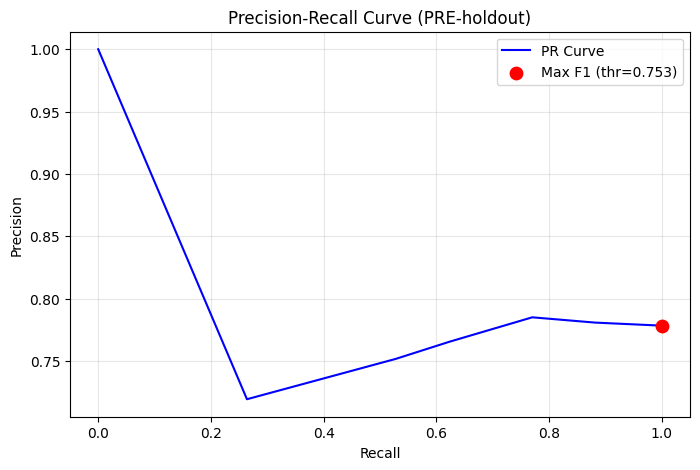

Inner validation start (within pre-holdout): 2024-02-22


KeyboardInterrupt: 

In [ ]:
# Step 3: Threshold Optimization & Performance Visualization 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve, confusion_matrix
from lightgbm import plot_importance

from at.backtest.simulator import backtest_equal_weight, BacktestConfig
from at.backtest.metrics import annualized_sharpe

# Use out-of-sample meta_prob rows only
mask = df["meta_prob"].notna() & df["meta_y"].notna() & df["trade_ret"].notna()
eval_df = df.loc[mask, ["date", "ticker", "meta_prob", "meta_y", "trade_ret"]].copy()
eval_df["date"] = pd.to_datetime(eval_df["date"])
eval_df = eval_df.sort_values(["date", "ticker"]).reset_index(drop=True)

eval_df["trade_ret_1d"] = eval_df["trade_ret"].astype(float)

HOLDOUT_FRAC = 0.20
if len(eval_df) < 500:
    print(f"WARNING: Only {len(eval_df)} labeled trades available; holdout split may be noisy.")

holdout_start = pd.to_datetime(eval_df["date"].quantile(1.0 - HOLDOUT_FRAC)).normalize()
eval_df_pre = eval_df[eval_df["date"] < holdout_start].copy()
eval_df_holdout = eval_df[eval_df["date"] >= holdout_start].copy()

print("--- Threshold selection split (time) ---")
print(f"Holdout start: {holdout_start.date()} | pre-holdout trades={len(eval_df_pre)} | holdout trades={len(eval_df_holdout)}")
if eval_df_holdout.empty:
    print("WARNING: Holdout set is empty; falling back to using all rows for threshold selection.")
    eval_df_pre = eval_df.copy()

all_dates = pd.DatetimeIndex(pd.to_datetime(df["date"]).drop_duplicates().sort_values())
pre_dates = all_dates[all_dates < holdout_start]
holdout_dates = all_dates[all_dates >= holdout_start]
if len(pre_dates) == 0:
    pre_dates = all_dates

y_true = eval_df_pre["meta_y"].astype(int).to_numpy()
y_probs = eval_df_pre["meta_prob"].astype(float).to_numpy()

precs, recs, thrs = precision_recall_curve(y_true, y_probs)
f1s = 2 * (precs * recs) / (precs + recs + 1e-12)
if len(thrs) > 0:
    idx_f1 = int(np.argmax(f1s[:-1]))  
    best_thr_f1 = float(thrs[idx_f1])
    best_f1 = float(f1s[idx_f1])
    best_prec = float(precs[idx_f1])
    best_rec = float(recs[idx_f1])
else:
    best_thr_f1 = float(np.nan)
    best_f1 = float("nan")
    best_prec = float("nan")
    best_rec = float("nan")



plt.figure(figsize=(8, 5))
plt.plot(recs, precs, label="PR Curve", color="blue")
if np.isfinite(best_thr_f1):
    plt.scatter(
        [best_rec],
        [best_prec],
        color="red",
        s=80,
        label=f"Max F1 (thr={best_thr_f1:.3f})",
        zorder=5,
    )
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (PRE-holdout)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


INNER_VAL_FRAC = 0.20
val_start = pd.to_datetime(eval_df_pre["date"].quantile(1.0 - INNER_VAL_FRAC)).normalize()
print(f"Inner validation start (within pre-holdout): {val_start.date()}")

bt_cfg_thr = BacktestConfig(
    initial_capital=1_000_000.0,
    commission_bps=10.0,
    impact_k=0.10,
    max_gross_leverage=1.0,
)


def _get_continuous_position(entry: np.ndarray, exit: np.ndarray) -> np.ndarray:
    out = np.zeros(len(entry), dtype=int)
    current_pos = 0
    for i in range(len(entry)):
        if current_pos == 1:
            if bool(exit[i]):
                current_pos = 0
        else:
            if bool(entry[i]):
                current_pos = 1
        out[i] = current_pos
    return out


def _prepare_signals_for_threshold(df_in: pd.DataFrame, thr: float) -> pd.DataFrame:
    dfx = df_in.copy()
    dfx["date"] = pd.to_datetime(dfx["date"])
    dfx = dfx.sort_values(["date", "ticker"]).reset_index(drop=True)

    dfx["_don_high_20"] = dfx.groupby("ticker")["high"].transform(lambda x: x.shift(1).rolling(20).max())
    dfx["_don_low_10"] = dfx.groupby("ticker")["low"].transform(lambda x: x.shift(1).rolling(10).min())
    dfx["_sma_100"] = dfx.groupby("ticker")["close"].transform(lambda x: x.rolling(100).mean())

    entry_cond = (dfx["close"] > dfx["_don_high_20"]) & (dfx["close"] > dfx["_sma_100"])
    exit_cond = (dfx["close"] < dfx["_don_low_10"])

    tmp = dfx[["date", "ticker"]].copy()
    tmp["entry"] = entry_cond.fillna(False)
    tmp["exit"] = exit_cond.fillna(False)
    tmp["pos_primary"] = tmp.groupby("ticker", group_keys=False).apply(
        lambda g: pd.Series(_get_continuous_position(g["entry"].to_numpy(), g["exit"].to_numpy()), index=g.index)
    )

    thr = float(np.clip(thr, 0.0, 1.0))
    meta_entry_cond = entry_cond & (dfx["meta_prob"].fillna(0.0) >= thr)

    tmp_meta = dfx[["date", "ticker"]].copy()
    tmp_meta["entry"] = meta_entry_cond.fillna(False)
    tmp_meta["exit"] = exit_cond.fillna(False)
    tmp["pos_meta"] = tmp_meta.groupby("ticker", group_keys=False).apply(
        lambda g: pd.Series(_get_continuous_position(g["entry"].to_numpy(), g["exit"].to_numpy()), index=g.index)
    )

    dfx["signal_meta"] = tmp["pos_meta"].astype(int)
    dfx["_meta_entry"] = meta_entry_cond.fillna(False).astype(int)

    if "roll_vol_20d" in dfx.columns:
        dfx["weight"] = 1.0 / (dfx["roll_vol_20d"].astype(float) + 1e-9)
    elif "vol_20d" in dfx.columns:
        dfx["weight"] = 1.0 / (dfx["vol_20d"].astype(float) + 1e-9)
    else:
        dfx["weight"] = 1.0
    dfx["weight"] = dfx["weight"].clip(upper=2.0)

    return dfx


def _backtest_sharpe_on_window(df_in: pd.DataFrame, thr: float, start: pd.Timestamp, end: pd.Timestamp) -> dict:
    dfx = _prepare_signals_for_threshold(df_in, thr)
    res = backtest_equal_weight(dfx, signal_col="signal_meta", weight_col="weight", cfg=bt_cfg_thr)

    r = res["returns"]
    r_win = r.loc[(r.index >= start) & (r.index < end)]
    sharpe = annualized_sharpe(r_win)

    win_mask = (dfx["date"] >= start) & (dfx["date"] < end)
    held_by_day = dfx.loc[win_mask].groupby("date")["signal_meta"].sum()
    active_days = int((held_by_day > 0).sum()) if len(held_by_day) else 0
    avg_positions = float(held_by_day.mean()) if len(held_by_day) else 0.0

    entry_count = int(dfx.loc[win_mask, "_meta_entry"].sum())

    return {
        "thr": float(thr),
        "sharpe": float(sharpe) if np.isfinite(sharpe) else float("nan"),
        "avg_positions": float(avg_positions),
        "active_days": int(active_days),
        "entry_count": int(entry_count),
    }


qs = np.linspace(0.05, 0.995, 30)
thr_grid = np.unique(np.quantile(y_probs, qs))
thr_grid = np.clip(thr_grid, 0.0, 1.0)

# Tune on inner validation slice inside pre-holdout
pre_df_for_bt = df[df["date"] < holdout_start].copy()

rows = []
for thr in thr_grid:
    rows.append(_backtest_sharpe_on_window(pre_df_for_bt, float(thr), val_start, holdout_start))

perf_df = pd.DataFrame(rows).sort_values("thr").reset_index(drop=True)

# Guardrails: avoid selecting thresholds that produce trivial activity in the tuning window
min_active_days = 30
min_entries = max(50, int(0.01 * len(eval_df_pre)))

cand = perf_df[(perf_df["active_days"] >= min_active_days) & (perf_df["entry_count"] >= min_entries)]
if cand.empty:
    cand = perf_df[perf_df["active_days"] >= 5]

best_row = cand.loc[cand["sharpe"].idxmax()] if not cand.empty else perf_df.loc[perf_df["sharpe"].idxmax()]
best_thr_trade = float(best_row["thr"])

print("Trading objective: backtest-based tuning on INNER validation slice (PRE-holdout)")
print(
    f"  best_thr: {best_thr_trade:.4f} | val_sharpe={float(best_row['sharpe']):.3f} | "
    f"entries={int(best_row['entry_count'])} | active_days={int(best_row['active_days'])} | avg_pos/day={float(best_row['avg_positions']):.2f}"
)

# Holdout evaluation: run one full backtest with the chosen threshold, then slice to holdout
full_df_for_bt = df.copy()
dfx_full = _prepare_signals_for_threshold(full_df_for_bt, best_thr_trade)
res_full = backtest_equal_weight(dfx_full, signal_col="signal_meta", weight_col="weight", cfg=bt_cfg_thr)
r_full = res_full["returns"]

if len(holdout_dates) > 0:
    r_holdout = r_full.loc[r_full.index >= holdout_start]
    print("Holdout (time) performance at chosen trading threshold")
    print(f"  holdout_sharpe: {annualized_sharpe(r_holdout):.3f} | n_days={int(len(r_holdout))}")
else:
    print("Holdout performance: skipped (no holdout dates).")

# Update globals for backtest cell
THRESH = float(best_thr_trade)
META_THR = float(best_thr_trade)

fig, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={"width_ratios": [2, 1]})
axes[0].plot(perf_df["thr"], perf_df["sharpe"], label="Val Sharpe", color="black")
axes[0].axvline(best_thr_trade, color="green", linestyle="--", label=f"Chosen thr={best_thr_trade:.3f}")
axes[0].set_title("INNER-Validation Sharpe vs Meta Threshold (Backtest-based)")
axes[0].set_xlabel("Meta threshold")
axes[0].set_ylabel("Annualized Sharpe")
axes[0].grid(True, alpha=0.3)
axes[0].legend()

axes[1].plot(perf_df["thr"], perf_df["avg_positions"], label="avg pos/day", color="teal")
axes[1].axvline(best_thr_trade, color="green", linestyle="--")
axes[1].set_title("Capacity proxy (val window)")
axes[1].set_xlabel("Meta threshold")
axes[1].set_ylabel("Avg positions/day")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

y_pred = (y_probs >= best_thr_trade).astype(int)
cm = confusion_matrix(y_true, y_pred, normalize="true")

plt.figure(figsize=(5, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    cbar=False,
    xticklabels=["Skip", "Trade"],
    yticklabels=["Loser", "Winner"],
 )
plt.title(f"Normalized Confusion Matrix (Trading thr={best_thr_trade:.3f})")
plt.ylabel("True Outcome")
plt.xlabel("Model Decision")
plt.show()

if "models" in globals() and len(models) > 0:
    best_model = models[-1]
    try:
        fi = getattr(best_model, "feature_importances_", None)
        if fi is None or (np.asarray(fi).size > 0 and float(np.max(fi)) == 0.0):
            print("Skipping feature importance plot (no nonzero importances).")
        else:
            ax = plot_importance(
                best_model,
                importance_type="gain",
                max_num_features=15,
                title="LightGBM Feature Importance (Gain)",
            )
            plt.tight_layout()
            plt.show()
    except Exception as e:
        print(f"Skipping feature importance plot due to error: {e}")
else:
    print("No trained LightGBM model found to plot feature importance.")

plt.figure(figsize=(10, 5))
sns.histplot(
    data=eval_df_pre,
    x="meta_prob",
    hue="meta_y",
    bins=50,
    kde=True,
    palette={0: "red", 1: "green"},
    element="step",
    alpha=0.3,
 )
plt.axvline(best_thr_trade, color="green", linestyle="--", label=f"Trading thr ({best_thr_trade:.3f})")
if np.isfinite(best_thr_f1):
    plt.axvline(best_thr_f1, color="blue", linestyle=":", label=f"Max F1 thr ({best_thr_f1:.3f})")
plt.title("Probability Distribution: Winners (Green) vs Losers (Red)")
plt.xlabel("Predicted Probability")
plt.ylabel("Sample Count")
plt.legend(loc="upper right")
plt.grid(True, alpha=0.3)
plt.show()

# Plotting the feature vs predicted probability graph
target_feats = ["dist_sma50", "rsi_14"]
available_feats = [f for f in target_feats if f in df.columns]

if available_feats:
    temp_plot = df.loc[mask, available_feats + ["meta_prob"]].copy()

    plt.figure(figsize=(12, 5))
    for i, feat in enumerate(available_feats):
        plt.subplot(1, 2, i + 1)
        plot_data = temp_plot if len(temp_plot) < 2000 else temp_plot.sample(2000, random_state=42)
        plt.scatter(plot_data[feat], plot_data["meta_prob"], alpha=0.2, s=15, color="teal")
        plt.xlabel(feat)
        plt.ylabel("Predicted Probability")
        plt.title(f"{feat} vs Prediction")
        plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

print(f"Ready to backtest with META_THR = {META_THR:.4f} (tuned on inner validation, reported on holdout)")

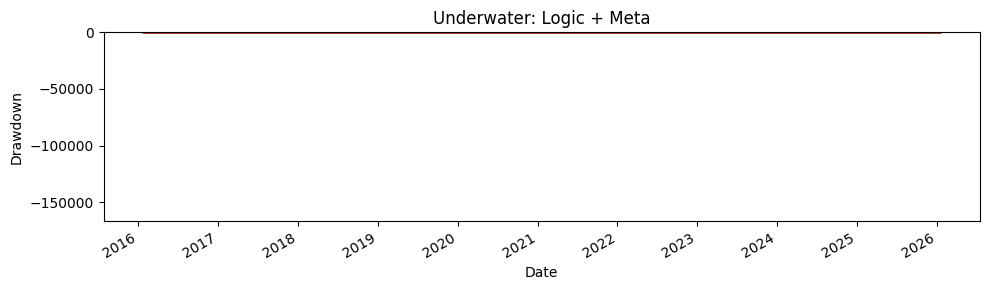

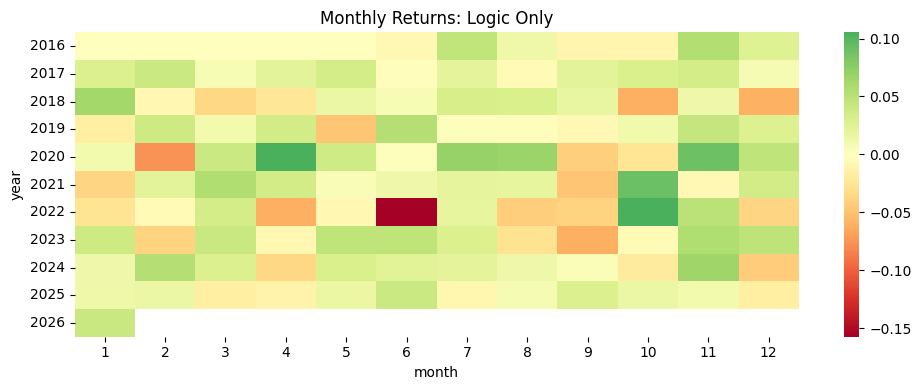

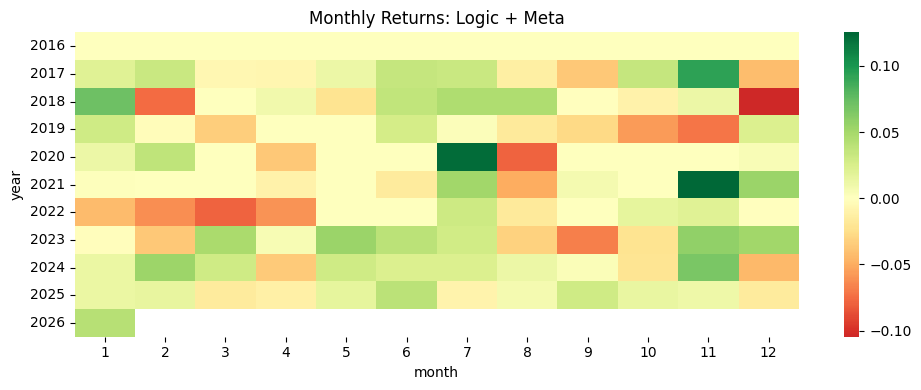

In [ ]:
# Plots
plot_equity_curve(eq_logic, title='Equity: Logic Only')
plot_equity_curve(eq_meta, title=f'Equity: Logic + Meta (thr={THRESH})')
plot_underwater(eq_logic, title='Underwater: Logic Only')
plot_underwater(eq_meta, title='Underwater: Logic + Meta')
plot_monthly_heatmap(r_logic, title='Monthly Returns: Logic Only')
plot_monthly_heatmap(r_meta, title='Monthly Returns: Logic + Meta')

In [ ]:
# Cumulative returns overlay: Benchmark vs Signal vs Meta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def _to_cumret(eq: pd.Series) -> pd.Series:
    s = eq.dropna()
    if s.empty:
        return eq * np.nan
    base = float(s.iloc[0])
    if base == 0:
        return eq * np.nan
    return (eq / base) - 1.0

# Prefer the already-stored series; fall back to backtest dicts if needed
eq_benchmark = globals().get("eq_bh") if "eq_bh" in globals() else (res_bh.get("equity") if "res_bh" in globals() else None)
eq_signal = globals().get("eq_logic") if "eq_logic" in globals() else (res_primary.get("equity") if "res_primary" in globals() else None)
eq_meta_local = globals().get("eq_meta") if "eq_meta" in globals() else (res_meta.get("equity") if "res_meta" in globals() else None)

if eq_benchmark is None or eq_signal is None or eq_meta_local is None:
    raise RuntimeError("Missing equity curves. Run the backtest cell that computes res_bh/res_primary/res_meta first.")

cum_df = pd.concat(
    {
        "Benchmark": _to_cumret(pd.Series(eq_benchmark)),
        "Signal": _to_cumret(pd.Series(eq_signal)),
        "Meta": _to_cumret(pd.Series(eq_meta_local)),
    },
    axis=1,
)

plt.figure(figsize=(12, 5))
for col in cum_df.columns:
    plt.plot(cum_df.index, cum_df[col], label=col)

if "holdout_start" in globals() and pd.notna(holdout_start):
    plt.axvline(pd.Timestamp(holdout_start), color="black", linestyle="--", linewidth=1, alpha=0.7, label="Holdout start")

plt.title("Cumulative Returns: Benchmark vs Signal vs Meta")
plt.ylabel("Cumulative return")
plt.xlabel("Date" if np.issubdtype(np.asarray(cum_df.index).dtype, np.datetime64) else "Index")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

## Report framing (what to say)

- **Equity curve crash = Regime Mismatch**: a trend-following thesis can fail badly in mean-reverting regimes.
- **Sensitivity table inversion = Predictive Inversion**: if higher confidence → worse returns, the model likely learned a real relationship but with the wrong sign (or regime flipped).
- **Stat-arb plot = ‘saving grace’**: even if broad alpha struggled, the pair overlay can surface market-neutral opportunities.

## 6) Stress test: threshold sensitivity

We sweep the meta threshold (0.50 → 0.65) and compare Sharpe + MaxDD.

In [ ]:
# Threshold sensitivity (Robust Model)
# Sweep different probability cutoffs (quantiles) and measure Sharpe/MaxDD.

prob_col = None
for c in ("layer1_prob", "meta_prob"):
    if c in df.columns:
        prob_col = c
        break
if prob_col is None:
    raise KeyError(
        "No probability column found. Expected one of: 'layer1_prob', 'meta_prob'. "
        f"Available columns: {sorted(df.columns.tolist())}"
    )

# NOTE: older versions of this notebook referenced df['safe_to_trade'] and df['market_bullish'],
# but those columns are not created anywhere in the pipeline. Derive reasonable defaults here.
if "entry_cond" in globals():
    safe_mask = entry_cond.fillna(False).astype(bool)
elif "entry_condition" in globals():
    safe_mask = entry_condition.fillna(False).astype(bool)
elif "signal_a" in df.columns:
    safe_mask = (df["signal_a"].fillna(0) != 0)
else:
    safe_mask = pd.Series(True, index=df.index)

if "market_bullish" in df.columns:
    regime_mask = df["market_bullish"].fillna(1).astype(int)
else:
    # No regime filter available in df; default to pass-through (no extra gating).
    regime_mask = pd.Series(1, index=df.index, dtype=int)

quantiles = [0.80, 0.85, 0.90, 0.95]
rows = []
for q in quantiles:
    thr = float(df[prob_col].quantile(q))
    sig = ((df[prob_col] >= thr) & safe_mask).astype(int)
    sig = (sig * regime_mask).astype(int)

    df["signal_tmp"] = sig
    res = backtest_equal_weight(df, signal_col="signal_tmp", weight_col="weight", cfg=bt_cfg)
    eq = res["equity"]
    r = res["returns"]

    rows.append({
        "prob_col": prob_col,
        "quantile": q,
        "thr": thr,
        "avg_positions": float(df.loc[df["signal_tmp"] == 1].groupby("date")["ticker"].nunique().mean()) if (df["signal_tmp"] == 1).any() else 0.0,
        "sharpe": annualized_sharpe(r),
        "max_dd": max_drawdown(eq),
        "final_equity": float(eq.dropna().iloc[-1]) if len(eq.dropna()) else np.nan,
    })

pd.DataFrame(rows)

,prob_col,quantile,thr,avg_positions,sharpe,max_dd,final_equity
0,meta_prob,0.80,0.806192,1.727273,-0.403593,-0.289369,748364.225975
1,meta_prob,0.85,0.810607,1.921348,-0.375372,-0.222543,845641.926165
2,meta_prob,0.90,0.810607,1.921348,-0.375372,-0.222543,845641.926165
3,meta_prob,0.95,0.810607,1.921348,-0.375372,-0.222543,845641.926165


## 7) Statistical Arbitrage Overlay (Exploration)

Baseline discovery:
- Find top correlated pairs (Spearman) on returns
- Then run cointegration tests on those candidates

In [ ]:
prices = df.pivot(index='date', columns='ticker', values='close').sort_index()
pairs = top_correlated_pairs(prices, top_k=30, method='spearman', min_overlap=200)
pairs.head(10)

,a,b,corr
0,Asset_010,Asset_016,0.859918
1,Asset_014,Asset_028,0.849927
2,Asset_067,Asset_068,0.844370
3,Asset_028,Asset_078,0.825610
4,Asset_013,Asset_021,0.825416
5,Asset_043,Asset_074,0.821035
6,Asset_014,Asset_078,0.810178
7,Asset_020,Asset_052,0.809252
8,Asset_028,Asset_042,0.790623
9,Asset_028,Asset_068,0.782622


In [ ]:
coint = cointegration_scan(prices, pairs, max_pairs=30)
coint.head(10)

,a,b,coint_pvalue,coint_stat,corr
0,Asset_010,Asset_016,0.001743,-4.405562,0.859918
1,Asset_051,Asset_100,0.010682,-3.876608,0.751589
2,Asset_028,Asset_083,0.026015,-3.578881,0.710047
3,Asset_031,Asset_039,0.028779,-3.542878,0.753519
4,Asset_020,Asset_052,0.138041,-2.892418,0.809252
5,Asset_017,Asset_098,0.347197,-2.353470,0.720397
6,Asset_013,Asset_021,0.351981,-2.343660,0.825416
7,Asset_028,Asset_068,0.395532,-2.256335,0.782622
8,Asset_028,Asset_042,0.476473,-2.099797,0.790623
9,Asset_021,Asset_094,0.478929,-2.095100,0.733822


### Asset_010 vs Asset_016 (spread + z-score)

This is the plot you can drop into the final report:
- Compute $\beta$ from prices (simple regression)
- Spread = Price010 − (β × Price016)
- Plot spread z-score (mean reversion signal)

beta: 0.35260871603773475
cointegration p-value: 0.0017432607134675922


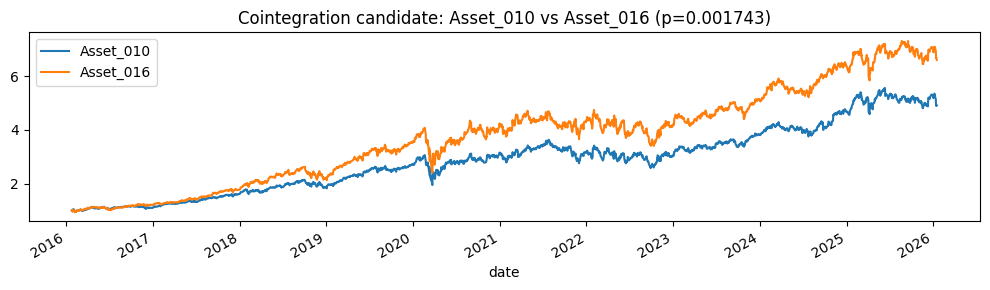

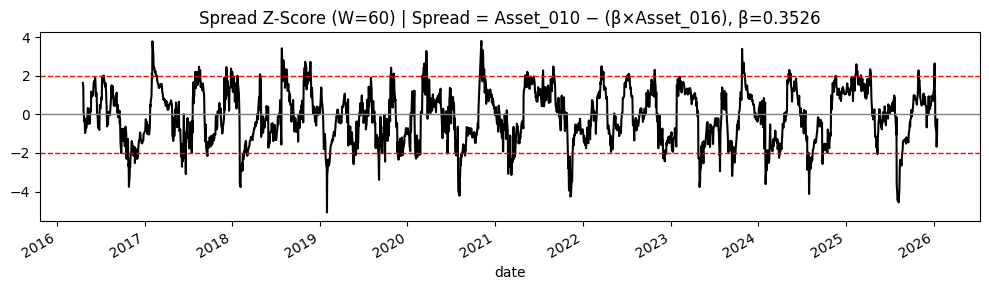

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint as eg_coint

t1, t2 = 'Asset_010', 'Asset_016'

if t1 not in prices.columns or t2 not in prices.columns:
    raise KeyError(f'Missing one of required tickers: {t1}, {t2}')

p1 = prices[t1].dropna()
p2 = prices[t2].dropna()
idx = p1.index.intersection(p2.index)
p1 = p1.loc[idx]
p2 = p2.loc[idx]

# Estimate beta (no intercept) for Spread = P1 - beta*P2
beta = float((p1 * p2).sum() / (p2 * p2).sum())
spread = p1 - beta * p2

# Cointegration p-value for the report claim
stat, pval, _ = eg_coint(p1, p2)
print('beta:', beta)
print('cointegration p-value:', float(pval))

# Z-score the spread
W = 60
mu = spread.rolling(W, min_periods=W).mean()
sd = spread.rolling(W, min_periods=W).std(ddof=0)
z = (spread - mu) / sd

# Price co-movement plot (normalized)
plt.figure(figsize=(10, 3))
(p1 / p1.iloc[0]).plot(label=t1)
(p2 / p2.iloc[0]).plot(label=t2)
plt.title(f'Cointegration candidate: {t1} vs {t2} (p={pval:.4g})')
plt.legend()
plt.tight_layout()
plt.show()

# Spread z-score plot
plt.figure(figsize=(10, 3))
z.plot(color='black')
plt.axhline(0.0, color='gray', linewidth=1)
plt.axhline(2.0, color='red', linestyle='--', linewidth=1)
plt.axhline(-2.0, color='red', linestyle='--', linewidth=1)
plt.title(f'Spread Z-Score (W={W}) | Spread = {t1} − (β×{t2}), β={beta:.4f}')
plt.tight_layout()
plt.show()

### Overlay idea (write-up template)

Suggested framing:
- Broad market ML can struggle under **regime shifts** (relationships flip).
- A statsarb sleeve can still find **market-neutral** mean reversion if pairs are cointegrated.

Example wording (edit based on the printed p-value above):
- "While the broad alpha strategy struggled due to regime mismatch, the Asset_010 vs Asset_016 overlay showed cointegration (p-value < 0.01 ≈ 99% confidence), creating market-neutral opportunities."